In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score

import scipy.stats as stats

In [2]:
df = pd.read_csv('stock fundamental data.csv')
df.head()
len(df)

50560

# Preprocessing data


In [3]:
# check for any null values in market value 
df.isnull().sum()

gvkey          0
tic            0
fyear         51
indfmt         0
consol         0
popsrc         0
datafmt        0
curcd         51
act        21788
ap         10863
at          6722
ceq         6843
che        13777
cogs       13868
dlc         7086
dlcch      31465
dltt        6884
dp          9347
dvc         7149
ib          6821
intan       7427
invt       12160
ivao       15275
lct        21720
lt          6792
nopio      17628
ppent       8714
rect       14032
sale       13865
spi         7300
txp        15200
txt         6826
xad        35615
xido        6821
xint       12512
xrd        31021
xsga       19673
costat         0
mkvalt     14697
dtype: int64

In [4]:
#create column 'future mkvalt' that holds the market value of the next year
condition1 = df['tic'].shift(-1) == df['tic']
condition2 = df['fyear'].shift(-1) == df['fyear'] + 1
df['future_mkvalt'] = np.where(condition1 & condition2, df['mkvalt'].shift(-1), np.nan)

#drop nulls
df = df.dropna(subset=['mkvalt', 'future_mkvalt'], how='all')

#percent change is the percent change in market value from one year to the next
df['percent_change'] = (df['future_mkvalt']-df['mkvalt'])/df['mkvalt']

#if percent change is greater than 20%, classify as undervalued
df['undervalued'] = (df['percent_change'] > 0.10)

In [5]:
#fill null expenses with 0
df['xrd'] = df['xrd'].fillna(0)
df['xad'] = df['xad'].fillna(0)
df['xsga'] = df['xsga'].fillna(0)
df['xint'] = df['xint'].fillna(0)
df['dlcch'] = df['dlcch'].fillna(0)



#combine all expenses columns into one column
expenses_list = ['xrd', 'xad', 'xsga', 'xint', 'nopio', 'cogs']
df['expenses'] = df[expenses_list].sum(axis=1)

df = df.drop(columns=expenses_list)

#delete duplicate rows due to formatting
condition = df['indfmt'] != "FS"
df = df[condition]

#drop unneccessary columns
df = df.drop(columns=['indfmt', 'consol', 'popsrc', 'datafmt', 'curcd', 'gvkey', 'costat'])




In [6]:
#remove rows with null values
condition = df.isnull().sum(axis=1) < 1
df = df[condition]

In [7]:
df.head(5)

,tic,fyear,act,ap,at,ceq,che,dlc,dlcch,dltt,...,sale,spi,txp,txt,xido,mkvalt,future_mkvalt,percent_change,undervalued,expenses
0,AIR,2009.0,863.429,114.906,1501.042,746.906,79.370,100.833,-4.996,336.191,...,1352.151,-4.302,3.263,20.986,0.000,777.8348,1049.8206,0.349670,True,1243.600
1,AIR,2010.0,913.985,185.096,1703.727,835.845,57.433,114.075,54.991,329.802,...,1775.782,-1.536,0.000,35.364,-3.313,1049.8206,485.2897,-0.537740,False,1613.484
2,AIR,2011.0,1063.272,201.405,2195.653,864.649,67.720,122.865,0.000,669.489,...,2074.498,-13.864,0.000,25.480,0.000,485.2897,790.0029,0.627900,True,1891.119
3,AIR,2012.0,1033.700,149.300,2136.900,918.600,75.300,86.400,0.000,622.200,...,2167.100,-21.100,0.000,26.700,0.000,790.0029,961.3080,0.216841,True,1970.300
4,AIR,2013.0,1116.900,171.100,2199.500,999.500,89.200,69.700,10.000,564.300,...,2035.000,0.000,0.000,32.100,0.000,961.3080,1046.3954,0.088512,False,1824.100


In [8]:
# check for any null values
df.isnull().sum()

tic               0
fyear             0
act               0
ap                0
at                0
ceq               0
che               0
dlc               0
dlcch             0
dltt              0
dp                0
dvc               0
ib                0
intan             0
invt              0
ivao              0
lct               0
lt                0
ppent             0
rect              0
sale              0
spi               0
txp               0
txt               0
xido              0
mkvalt            0
future_mkvalt     0
percent_change    0
undervalued       0
expenses          0
dtype: int64

In [9]:
# new length of df after processing
len(df)

18538

# Remove target variable outliers

Text(0.5, 0, 'Percent Increase in market value over 1 year period')

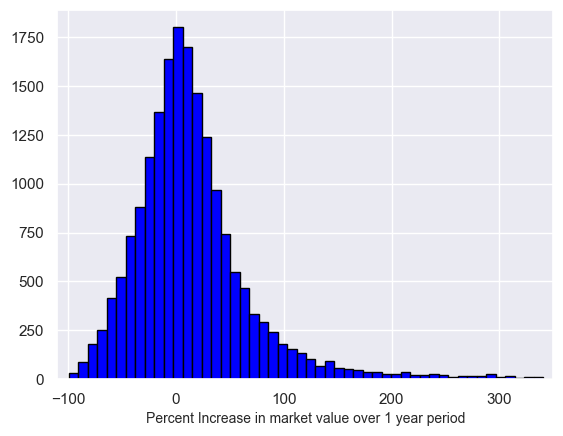

In [10]:
binwidth=0.1
    
# Set up the plot
plot = plt.subplot(1, 1, 1 )
    
# Draw the plot
plot.hist(df['percent_change']*100, bins = int(180/binwidth),
             color = 'blue', edgecolor = 'black')
    
    # Title and labels
plt.xlim(-110, 350)
plot.set_xlabel('Percent Increase in market value over 1 year period', size = 10)

In [11]:
#remove outliers
condition1 = df['percent_change'] < 1
df = df[condition1]

Text(0.5, 0, 'Percent Increase in market value over 1 year period')

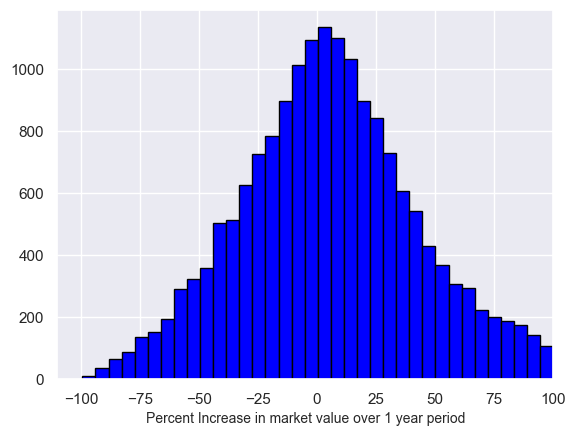

In [12]:
#replot
binwidth=5
    
# Set up the plot
plot = plt.subplot(1, 1, 1 )
plot.hist(df['percent_change']*100, bins = int(180/binwidth),
             color = 'blue', edgecolor = 'black')
    
#Title and labels
plt.xlim(-110, 100)
plot.set_xlabel('Percent Increase in market value over 1 year period', size = 10)

# Feature Engineering

In [14]:
#feature selection 
from sklearn.feature_selection import SelectKBest, f_classif,f_regression

#features and predict value
Features = list(df.drop(columns=['tic','fyear','undervalued','percent_change','future_mkvalt','spi']).columns)

X = df[Features]
y = df['undervalued']

# find best features 
fs = SelectKBest(score_func=f_classif, k=9)

X_selected = fs.fit_transform(X,y)

In [15]:
# best features according to pearson test 
selected_features = fs.get_feature_names_out()
X = df[selected_features]
selected_features

array(['act', 'at', 'che', 'dltt', 'intan', 'lct', 'lt', 'rect', 'mkvalt'],
      dtype=object)

In [16]:
#split the data
X_train = X.iloc[3800:]
X_test = X.iloc[:3800]
y_train = y.iloc[3800:]
y_test = y.iloc[:3800]

# Functions for model evaluation and building 

In [17]:
# build pipline which evaluates models 
def build_and_eval_classification_model(model, X_train, y_train, X_test, y_test):
    
    print("running model report",model)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model.fit(X_train_scaled,y_train)
    
    y_pred = model.predict(X_test_scaled)
    
    accuracy = accuracy_score(y_test,y_pred)
    print("\nAccuracy Score: %f" % accuracy)

    precision = precision_score(y_test,y_pred)
    print("Precision Score: %f" % precision)

    recall = recall_score(y_test,y_pred)
    print("Recall Score: %f" % recall)

    f1 = f1_score(y_test,y_pred)
    print('F1 Score: %f' % f1)

    # Calculate predicted probabilities
    y_pred_proba = model.predict_proba(X_test)

    # Keep only the proba for True
    y_pred_proba = y_pred_proba[:,1]

    # Compute auc score
    auc = roc_auc_score(y_true = y_test, y_score = y_pred_proba )
    print('AUC Score: %f' % auc)
    
    return y_pred

In [18]:
# find the total return if you would invest in certain companies 
def find_return(model,y_test,undervalued_y_pred):
    undervalued_y_pred = undervalued_y_pred.tolist()
    gains = 0
    investment = 0
    arr = y_test.index
    len(arr)
    for i in range(len(undervalued_y_pred)):
        if(undervalued_y_pred[i]):
            index = arr[i]
            investment = investment + 100
            change = 100  + 100 * (df.loc[[index]]['percent_change'].values)
            gains = gains + change
            
#     convert gains to list so we can remove the value for formatting
    if model != DecisionTreeClassifier():
        gains = gains.tolist()
        gains = gains[0]
    
    
    percent_increase = (gains - investment)/investment      
    print("\nreturn for model",model)
    print('Initial Investment: ${investment: .2f}'.format(investment = investment))
    print('Total Return: ${gains: .2f}' .format(gains=gains))
    print('Percent increase: {percent_increase: .2f}'.format(percent_increase= percent_increase))  
   

In [19]:
# choose model and hyperparameters then run a grids search to find best paramaters
#Grid search for decision tree
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

DT_model = DecisionTreeClassifier()

params = {'criterion' : ['entropy','gini'],
        'max_depth': [3,5,7],
        'min_samples_leaf': [5,10, 25],
        'min_samples_split': [8, 10, 12],
        'max_features' : [2,6,8,None]
          }

gs = GridSearchCV(estimator=DT_model,
                      param_grid=params,cv=3,verbose=2,scoring='precision',
                      refit=True,return_train_score=False)

gs.fit(X_train_scaled, y_train)
gs.best_params_

Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV] END criterion=entropy, max_depth=3, max_features=2, min_samples_leaf=5, min_samples_split=8; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_features=2, min_samples_leaf=5, min_samples_split=8; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_features=2, min_samples_leaf=5, min_samples_split=8; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_features=2, min_samples_leaf=5, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_features=2, min_samples_leaf=5, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_features=2, min_samples_leaf=5, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_features=2, min_samples_leaf=5, min_samples_split=12; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_features=2, min_samples_leaf=5, min_samples_split=12; total time=   0

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Librar

[CV] END criterion=entropy, max_depth=3, max_features=2, min_samples_leaf=25, min_samples_split=12; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_features=2, min_samples_leaf=25, min_samples_split=12; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_features=6, min_samples_leaf=5, min_samples_split=8; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_features=6, min_samples_leaf=5, min_samples_split=8; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_features=6, min_samples_leaf=5, min_samples_split=8; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_features=6, min_samples_leaf=5, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_features=6, min_samples_leaf=5, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_features=6, min_samples_leaf=5, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_features=6, 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END criterion=entropy, max_depth=3, max_features=6, min_samples_leaf=10, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_features=6, min_samples_leaf=10, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_features=6, min_samples_leaf=10, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_features=6, min_samples_leaf=10, min_samples_split=12; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_features=6, min_samples_leaf=10, min_samples_split=12; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_features=6, min_samples_leaf=10, min_samples_split=12; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_features=6, min_samples_leaf=25, min_samples_split=8; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_features=6, min_samples_leaf=25, min_samples_split=8; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_featu

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END criterion=entropy, max_depth=3, max_features=6, min_samples_leaf=25, min_samples_split=12; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_features=8, min_samples_leaf=5, min_samples_split=8; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_features=8, min_samples_leaf=5, min_samples_split=8; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_features=8, min_samples_leaf=5, min_samples_split=8; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_features=8, min_samples_leaf=5, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_features=8, min_samples_leaf=5, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_features=8, min_samples_leaf=5, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_features=8, min_samples_leaf=5, min_samples_split=12; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_features=8, m

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END criterion=entropy, max_depth=3, max_features=8, min_samples_leaf=25, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_features=8, min_samples_leaf=25, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_features=8, min_samples_leaf=25, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_features=8, min_samples_leaf=25, min_samples_split=12; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_features=8, min_samples_leaf=25, min_samples_split=12; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_features=8, min_samples_leaf=25, min_samples_split=12; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_features=None, min_samples_leaf=5, min_samples_split=8; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_features=None, min_samples_leaf=5, min_samples_split=8; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_f

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Librar

[CV] END criterion=entropy, max_depth=3, max_features=None, min_samples_leaf=10, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_features=None, min_samples_leaf=10, min_samples_split=12; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_features=None, min_samples_leaf=10, min_samples_split=12; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_features=None, min_samples_leaf=10, min_samples_split=12; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_features=None, min_samples_leaf=25, min_samples_split=8; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_features=None, min_samples_leaf=25, min_samples_split=8; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_features=None, min_samples_leaf=25, min_samples_split=8; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_features=None, min_samples_leaf=25, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy,

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END criterion=entropy, max_depth=3, max_features=None, min_samples_leaf=25, min_samples_split=12; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_features=None, min_samples_leaf=25, min_samples_split=12; total time=   0.0s
[CV] END criterion=entropy, max_depth=3, max_features=None, min_samples_leaf=25, min_samples_split=12; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_features=2, min_samples_leaf=5, min_samples_split=8; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_features=2, min_samples_leaf=5, min_samples_split=8; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_features=2, min_samples_leaf=5, min_samples_split=8; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_features=2, min_samples_leaf=5, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_features=2, min_samples_leaf=5, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_fe

[CV] END criterion=entropy, max_depth=5, max_features=8, min_samples_leaf=10, min_samples_split=12; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_features=8, min_samples_leaf=25, min_samples_split=8; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_features=8, min_samples_leaf=25, min_samples_split=8; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_features=8, min_samples_leaf=25, min_samples_split=8; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_features=8, min_samples_leaf=25, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_features=8, min_samples_leaf=25, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_features=8, min_samples_leaf=25, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_features=8, min_samples_leaf=25, min_samples_split=12; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_featur

[CV] END criterion=entropy, max_depth=7, max_features=6, min_samples_leaf=10, min_samples_split=8; total time=   0.0s
[CV] END criterion=entropy, max_depth=7, max_features=6, min_samples_leaf=10, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=7, max_features=6, min_samples_leaf=10, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=7, max_features=6, min_samples_leaf=10, min_samples_split=10; total time=   0.0s
[CV] END criterion=entropy, max_depth=7, max_features=6, min_samples_leaf=10, min_samples_split=12; total time=   0.0s
[CV] END criterion=entropy, max_depth=7, max_features=6, min_samples_leaf=10, min_samples_split=12; total time=   0.0s
[CV] END criterion=entropy, max_depth=7, max_features=6, min_samples_leaf=10, min_samples_split=12; total time=   0.0s
[CV] END criterion=entropy, max_depth=7, max_features=6, min_samples_leaf=25, min_samples_split=8; total time=   0.0s
[CV] END criterion=entropy, max_depth=7, max_featu

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Librar

[CV] END criterion=gini, max_depth=3, max_features=2, min_samples_leaf=5, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=2, min_samples_leaf=5, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=2, min_samples_leaf=5, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=2, min_samples_leaf=5, min_samples_split=12; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=2, min_samples_leaf=5, min_samples_split=12; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=2, min_samples_leaf=5, min_samples_split=12; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=2, min_samples_leaf=10, min_samples_split=8; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=2, min_samples_leaf=10, min_samples_split=8; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=2, min_samples_leaf=10, min_s

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END criterion=gini, max_depth=3, max_features=6, min_samples_leaf=25, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=6, min_samples_leaf=25, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=6, min_samples_leaf=25, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=6, min_samples_leaf=25, min_samples_split=12; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=6, min_samples_leaf=25, min_samples_split=12; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=6, min_samples_leaf=25, min_samples_split=12; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=8, min_samples_leaf=5, min_samples_split=8; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=8, min_samples_leaf=5, min_samples_split=8; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=8, min_samples_leaf=5, mi

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Librar

[CV] END criterion=gini, max_depth=3, max_features=8, min_samples_leaf=5, min_samples_split=12; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=8, min_samples_leaf=10, min_samples_split=8; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=8, min_samples_leaf=10, min_samples_split=8; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=8, min_samples_leaf=10, min_samples_split=8; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=8, min_samples_leaf=10, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=8, min_samples_leaf=10, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=8, min_samples_leaf=10, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=8, min_samples_leaf=10, min_samples_split=12; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=8, min_samples_leaf=10, m

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Librar

[CV] END criterion=gini, max_depth=3, max_features=8, min_samples_leaf=25, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=8, min_samples_leaf=25, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=8, min_samples_leaf=25, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=8, min_samples_leaf=25, min_samples_split=12; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=8, min_samples_leaf=25, min_samples_split=12; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=8, min_samples_leaf=25, min_samples_split=12; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=None, min_samples_leaf=5, min_samples_split=8; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=None, min_samples_leaf=5, min_samples_split=8; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=None, min_samples_l

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Librar

[CV] END criterion=gini, max_depth=3, max_features=None, min_samples_leaf=5, min_samples_split=12; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=None, min_samples_leaf=5, min_samples_split=12; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=None, min_samples_leaf=5, min_samples_split=12; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=None, min_samples_leaf=10, min_samples_split=8; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=None, min_samples_leaf=10, min_samples_split=8; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=None, min_samples_leaf=10, min_samples_split=8; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=None, min_samples_leaf=10, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=None, min_samples_leaf=10, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=Non

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Librar

[CV] END criterion=gini, max_depth=3, max_features=None, min_samples_leaf=10, min_samples_split=12; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=None, min_samples_leaf=25, min_samples_split=8; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=None, min_samples_leaf=25, min_samples_split=8; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=None, min_samples_leaf=25, min_samples_split=8; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=None, min_samples_leaf=25, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=None, min_samples_leaf=25, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=None, min_samples_leaf=25, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=None, min_samples_leaf=25, min_samples_split=12; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END criterion=gini, max_depth=5, max_features=2, min_samples_leaf=5, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=2, min_samples_leaf=5, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=2, min_samples_leaf=5, min_samples_split=12; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=2, min_samples_leaf=5, min_samples_split=12; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=2, min_samples_leaf=5, min_samples_split=12; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=2, min_samples_leaf=10, min_samples_split=8; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=2, min_samples_leaf=10, min_samples_split=8; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=2, min_samples_leaf=10, min_samples_split=8; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=2, min_samples_leaf=10, min_s

[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=8; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=12; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=12; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=5, min_samples_split=12; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_leaf=10, min_samples_split=8; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=None, 

[CV] END criterion=gini, max_depth=7, max_features=6, min_samples_leaf=25, min_samples_split=12; total time=   0.0s
[CV] END criterion=gini, max_depth=7, max_features=6, min_samples_leaf=25, min_samples_split=12; total time=   0.0s
[CV] END criterion=gini, max_depth=7, max_features=8, min_samples_leaf=5, min_samples_split=8; total time=   0.0s
[CV] END criterion=gini, max_depth=7, max_features=8, min_samples_leaf=5, min_samples_split=8; total time=   0.0s
[CV] END criterion=gini, max_depth=7, max_features=8, min_samples_leaf=5, min_samples_split=8; total time=   0.0s
[CV] END criterion=gini, max_depth=7, max_features=8, min_samples_leaf=5, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=7, max_features=8, min_samples_leaf=5, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=7, max_features=8, min_samples_leaf=5, min_samples_split=10; total time=   0.0s
[CV] END criterion=gini, max_depth=7, max_features=8, min_samples_leaf=5, min_sam

{'criterion': 'gini',
 'max_depth': 3,
 'max_features': 6,
 'min_samples_leaf': 25,
 'min_samples_split': 8}

In [20]:
rf_model = RandomForestClassifier()

params = [{'n_estimators': [100, 200, 400],
        'max_depth': [5, 6, 7, 8],
        'min_samples_leaf': [3, 5, 7],
        'min_samples_split': [8, 10, 12],
          }]

gs = GridSearchCV(rf_model,
                      param_grid=params,
                      scoring='precision',
                      cv=3, verbose=2, return_train_score=False)
gs.fit(X_train_scaled, y_train)
gs.best_params_

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END max_depth=5, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   0.7s
[CV] END max_depth=5, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   0.7s
[CV] END max_depth=5, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   0.7s
[CV] END max_depth=5, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=   1.3s
[CV] END max_depth=5, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=   1.3s
[CV] END max_depth=5, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=   1.3s
[CV] END max_depth=5, min_samples_leaf=3, min_samples_split=8, n_estimators=400; total time=   2.7s
[CV] END max_depth=5, min_samples_leaf=3, min_samples_split=8, n_estimators=400; total time=   2.6s
[CV] END max_depth=5, min_samples_leaf=3, min_samples_split=8, n_estimators=400; total time=   2.7s
[CV] END max_depth=5, min_samples_lea

[CV] END max_depth=6, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   0.8s
[CV] END max_depth=6, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   0.8s
[CV] END max_depth=6, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   0.8s
[CV] END max_depth=6, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=   1.6s
[CV] END max_depth=6, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=   1.6s
[CV] END max_depth=6, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=   1.6s
[CV] END max_depth=6, min_samples_leaf=3, min_samples_split=8, n_estimators=400; total time=   3.1s
[CV] END max_depth=6, min_samples_leaf=3, min_samples_split=8, n_estimators=400; total time=   3.1s
[CV] END max_depth=6, min_samples_leaf=3, min_samples_split=8, n_estimators=400; total time=   3.1s
[CV] END max_depth=6, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   0.8s

[CV] END max_depth=7, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   0.9s
[CV] END max_depth=7, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   0.9s
[CV] END max_depth=7, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=   1.8s
[CV] END max_depth=7, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=   1.7s
[CV] END max_depth=7, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=   1.8s
[CV] END max_depth=7, min_samples_leaf=3, min_samples_split=8, n_estimators=400; total time=   3.5s
[CV] END max_depth=7, min_samples_leaf=3, min_samples_split=8, n_estimators=400; total time=   3.5s
[CV] END max_depth=7, min_samples_leaf=3, min_samples_split=8, n_estimators=400; total time=   3.5s
[CV] END max_depth=7, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   0.9s
[CV] END max_depth=7, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   0.9

[CV] END max_depth=8, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   1.0s
[CV] END max_depth=8, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=   2.0s
[CV] END max_depth=8, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=   1.9s
[CV] END max_depth=8, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=   1.9s
[CV] END max_depth=8, min_samples_leaf=3, min_samples_split=8, n_estimators=400; total time=   3.9s
[CV] END max_depth=8, min_samples_leaf=3, min_samples_split=8, n_estimators=400; total time=   3.9s
[CV] END max_depth=8, min_samples_leaf=3, min_samples_split=8, n_estimators=400; total time=   3.9s
[CV] END max_depth=8, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   1.0s
[CV] END max_depth=8, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   1.0s
[CV] END max_depth=8, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   1.

{'max_depth': 5,
 'min_samples_leaf': 3,
 'min_samples_split': 12,
 'n_estimators': 200}

# Build and Evaluate classification models 

models prediction is evaluated. We then run the find return function to find what your gains would be if you would invest in the stocks that our model predicted as undervalued 

In [21]:
# random forest test and returns 
rf = RandomForestClassifier(max_depth = 5, min_samples_leaf=3, min_samples_split=12, n_estimators=200)

# evaluate model 
y_pred_rf = build_and_eval_classification_model(rf, X_train, y_train, X_test, y_test)
# find returns 
find_return(rf,y_test,y_pred_rf)

running model report RandomForestClassifier(max_depth=5, min_samples_leaf=3, min_samples_split=12,
                       n_estimators=200)

Accuracy Score: 0.550263
Precision Score: 0.532847
Recall Score: 0.042491
F1 Score: 0.078706
AUC Score: 0.511172

return for model RandomForestClassifier(max_depth=5, min_samples_leaf=3, min_samples_split=12,
                       n_estimators=200)
Initial Investment: $ 13700.00
Total Return: $ 15098.31
Percent increase:  0.10


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [22]:
# logistic regression test and returns 
lr = LogisticRegression()

# evaluate model 
y_pred_lr = build_and_eval_classification_model(lr, X_train, y_train, X_test, y_test)

# find returns 
find_return(lr,y_test,y_pred_lr)

running model report LogisticRegression()

Accuracy Score: 0.539474
Precision Score: 0.444828
Recall Score: 0.075087
F1 Score: 0.128486
AUC Score: 0.482367

return for model LogisticRegression()
Initial Investment: $ 29000.00
Total Return: $ 31268.62
Percent increase:  0.08


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [23]:
# k nearest test and returns 
k = 131
knclas = KNeighborsClassifier(n_neighbors= k)

# test conversion
y_pred_kn = build_and_eval_classification_model(knclas, X_train, y_train, X_test, y_test)

# find returns 
find_return(knclas,y_test,y_pred_kn)

running model report KNeighborsClassifier(n_neighbors=131)

Accuracy Score: 0.544211
Precision Score: 0.491139
Recall Score: 0.225844
F1 Score: 0.309410
AUC Score: 0.489461

return for model KNeighborsClassifier(n_neighbors=131)
Initial Investment: $ 79000.00
Total Return: $ 87190.01
Percent increase:  0.10


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


In [26]:
# decision tree test and returns 
dt = DecisionTreeClassifier(criterion='gini', max_depth=3, max_features=6,
                       min_samples_leaf=25, min_samples_split=8)

# evaluate model  
y_pred_dt = build_and_eval_classification_model(dt, X_train, y_train, X_test, y_test)

# find returns 
find_return(dt,y_test,y_pred_dt)

running model report DecisionTreeClassifier(max_depth=3, max_features=6, min_samples_leaf=25,
                       min_samples_split=8)

Accuracy Score: 0.548421
Precision Score: 0.666667
Recall Score: 0.002328
F1 Score: 0.004640
AUC Score: 0.500000

return for model DecisionTreeClassifier(max_depth=3, max_features=6, min_samples_leaf=25,
                       min_samples_split=8)
Initial Investment: $ 600.00
Total Return: $ 816.20
Percent increase:  0.36


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
